# Introduction

This notebook will explore the thought process, and quality controls on gait signal. In making a better understanding of gait motion, especially in understanding how there are several key indicators on someone that has Parkinsons or multiple sclerosis, we are required to segment a gait by several motion category. Specifically this notebook will explore on the creation of gait motion annotator that is able to recognize signal into three basic categories: 

- <b> Walking Normally </b>
- <b> Resting </b>
- <b> Rotation and Turns </b>

Using the mPower app provided by Sage Bionetworks, we are able to gather huge amount of gait signal data, however our goal in this notebook is to provide better data quality for using it as a benchmark predictive model. Thus, our goal in this notebook is to singularize subject that actually walks, as well as isolating rotational movement so that it would not induce bias to the generated features.

In [22]:
import sys
sys.path.append("../src/pipeline")
from utils import query_utils as query
from utils import gait_features_utils as gproc
import synapseclient as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_style("dark")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
## log in to synapse for querying data in SageBionetworks ## 
syn = sc.login()

Welcome, aryton tediarjo!



INFO:synapseclient_default:Welcome, aryton tediarjo!



In [3]:
path_data = query.get_walking_synapse_table(syn, 
                                            "syn12514611", 
                                            "MPOWER_V2", 
                                            healthCodes = ["1fa674e9-2c49-4260-83f0-681ace2a5125", # parkinson
                                                          "c52432c0-754b-4490-b131-9684da102f6c", # control 
                                                          "e8167893-1b3a-4c71-94f4-5b3cb9b52165", # control
                                                          "f80e44ed-ce6f-4aff-8a6a-cfa74c823f6a"]) # parkinson

Querying MPOWER_V2 Data


[WARNING] /Users/atediarjo/Documents/SageBionetworks/synapse_venv/lib/python3.7/site-packages/synapseclient/client.py:3172: UserWarning: Weird file handle: None
  warnings.warn("Weird file handle: %s" % file_handle_id)

  warnings.warn("Weird file handle: %s" % file_handle_id)



INFO:synapseclient_default:Downloading 4 files, 258 cached locally


In [23]:
filepath = path_data["walk_motion.json_pathfile"].iloc[2]
accel_data = query.get_sensor_data_from_filepath(filepath, "userAcceleration")
rotation_data = query.get_sensor_data_from_filepath(filepath, "rotationRate")

TypeError: get_sensor_data_from_filepath() missing 1 required positional argument: 'sensor'

In [7]:
## package call ##
gaitFeaturize = gproc.GaitFeaturize()

# 1. Segmenting Rotation Motion

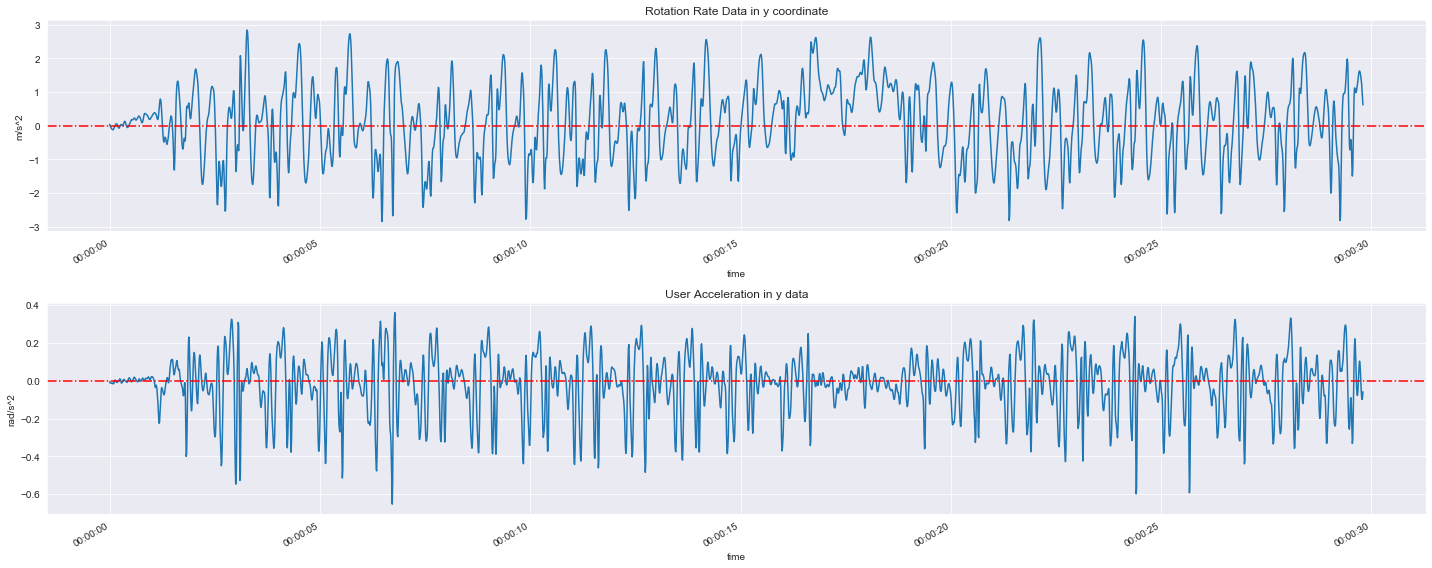

In [151]:
fig, axes = plt.subplots(2, 1)


rotation_data["y"].plot(grid = True, ax = axes[0], figsize = (20,8))
axes[0].set_title("Rotation Rate Data in y coordinate")
axes[0].set_ylabel("m/s^2")
axes[0].axhline(0, linestyle = "-.", color = "r")
# axes[0].axvline(17)

accel_data["y"].plot(grid = True, ax = axes[1], figsize = (20,8))
axes[1].set_title("User Acceleration in y data")
axes[1].set_ylabel("rad/s^2")
axes[1].axhline(0, linestyle = "-.", color = "r")

fig.tight_layout()
fig.show()

From the time-series data above, we can see that there are is a huge amount of increase on approximately the <b> 17th second </b>, ending on around the <b> 20th second </b>. This is an indication that a person is doing a rotational movement during the mPower Walking test. Thus, our goal is to isolate this sequence, so that we can take in some rotational features, as well as an unbiased features on the walking tests.

Per the reseach paper published by [name], to recognize rotational movement, here are the steps that we are going to implement for our own gait signal QC pipeline:
<b>
- Apply low-pass filter into the signal data
- Detect zero crossing occurences on the time-series data, and separate the data
- On each period separated by the zero crossing, calculate the AUC of the period to get radians
- Using AUC during the particular period, multiply by duration (radians.secs)
- For each AUC.time > 2, categorize as rotation occurences
</b>

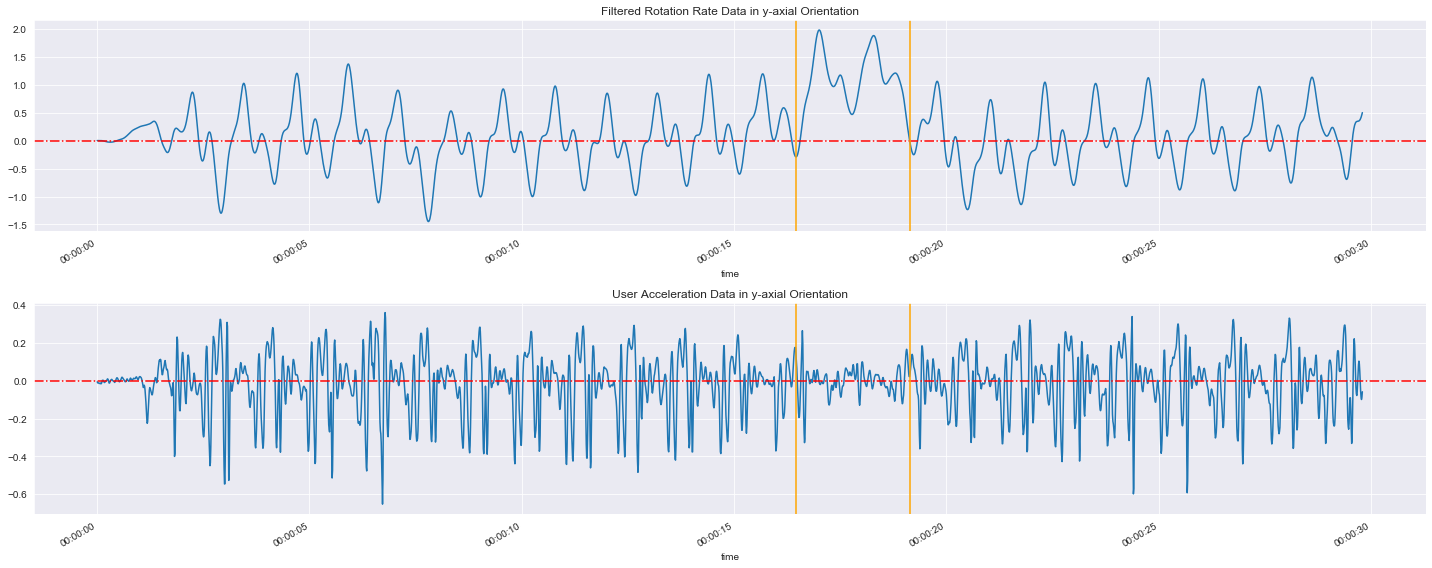

In [152]:
start = gproc.compute_rotational_features(accel_data, rotation_data)[0]['rotation.window_start']
end = gproc.compute_rotational_features(accel_data, rotation_data)[0]['rotation.window_end']
index_start = np.where(accel_data["td"] == start)
index_end = np.where(accel_data["td"] == end)


fig, axes = plt.subplots(2, 1)


rotation_data["y"].plot(grid = True, ax = axes[0], figsize = (20,8))
axes[0].set_title("Filtered Rotation Rate Data in y-axial Orientation")
axes[0].axhline(0, linestyle = "-.", color = "r")
axes[0].axvline(accel_data.iloc[index_start].index, color = "orange")
axes[0].axvline(accel_data.iloc[index_end].index, color = "orange")


accel_data["y"].plot(grid = True, ax = axes[1], figsize = (20,8))
axes[1].set_title("User Acceleration Data in y-axial Orientation")
axes[1].axhline(0, linestyle = "-.", color = "r")
axes[1].axvline(accel_data.iloc[index_start].index, color = "orange")
axes[1].axvline(accel_data.iloc[index_end].index, color = "orange")

fig.tight_layout()
fig.show()

In [160]:
## module for detecting rotation ##
pd.DataFrame(gproc.rotation_feature_pipeline(filepath)).T

,0
rotation.auc,2.90523
rotation.aucXt,7.3946
rotation.avg_number_of_strides,2
rotation.avg_step_duration,0.476667
rotation.avg_stride_duration,0.905
rotation.axis,y
rotation.cadence,1.57154
rotation.energy_freeze_index,3.67453
rotation.frequency_of_peaks,NaN
rotation.num_window,1


The implementation of the algorithm from the research paper (incorporated with other gait features during the rotation, will give you this following feature. Using the data dictionary and by plotting a vertical line on the detected rotation shows that there is a start of rotation at around 16th seconds to 19th seconds, which is consistent to our first hypothesis previously.

# 2. Segmenting Rest Motion (TODO)

# 3. Cadence Z-Score (Gait Festination Period)

In [ ]:
path_data["features"] = path_data["walk_motion.json_pathfile"].apply(gaitFeaturize.gait_feature_pipeline)
df = query.normalize_list_dicts_to_dataframe_rows(data = path_data[path_data["features"] != "#ERROR"], features = ["features"])